# Initial Setup

In [1]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

from utils.resnet import ResNet

print(tf.__version__)

2.2.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Imagenet Subset 

In [5]:
dataDir = '/data/datasets/cifar100/raw'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'models/cifar100_resnet50_adam_v5'
logsDir = 'logs/cifar100_resnet50_adam_v5'

In [6]:
BATCH_SIZE = 128
NUM_EPOCHS = 200
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 100
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [7]:
if not os.path.exists(configDir):
    os.makedirs(configDir)

if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
    os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
    os.makedirs(logsDir)

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [9]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [79]:
def rotate_zoom_tf(image, angle, zoom):

    angleRad = angle/180.*np.pi

    if image.shape.__len__() ==4:
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
        random_zoom = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = 1-zoom, maxval = 1+zoom)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
        random_zoom = tf.random.uniform(shape = (), minval = 1-zoom, maxval = 1+zoom)

    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, int(IMG_HEIGHT*random_zoom), int(IMG_WIDTH*random_zoom))
    img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)

    return img

def rotate_tf(image, angle):
    angleRad = angle/180.*np.pi

    if image.shape.__len__() ==4:   
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)

    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT, IMG_WIDTH)

    return img

def augment(image, label):
    #img = tf.image.rot90(image)
    img = tf.image.flip_left_right(image)
    #img = rotate_tf(image, 20)
    img = rotate_zoom_tf(image, 20, 0.2)
    #img = tf.image.random_brightness(img, 0.05)
    #img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)

    return (img, label)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
    if isinstance(cache, str):
        ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
    if isinstance(cache, str):
        ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [58]:
meta = unpickle(os.path.join(dataDir, 'meta'))
train = unpickle(os.path.join(dataDir, 'train'))
test = unpickle(os.path.join(dataDir, 'test'))

In [80]:
classDF = pd.DataFrame(meta[b'fine_label_names'], columns = ['Classes'], dtype=str)
CLASS_NAMES = np.array(classDF['Classes'])

In [81]:
trainX = np.vstack(train[b"data"])
trainX = trainX.reshape(len(trainX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
trainY = train[b'fine_labels']
trainY = tf.one_hot(trainY, NUM_CLASSES)

testX = np.vstack(test[b"data"])
testX = testX.reshape(len(testX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
testY = test[b'fine_labels']
testY = tf.one_hot(testY, NUM_CLASSES)

In [82]:
print(trainX.shape)
print(testX.shape)

print(trainY.shape)
print(testY.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 100)
(10000, 100)


In [83]:
trainLabelDS = tf.data.Dataset.from_tensor_slices((trainX, trainY))
valLabelDS = tf.data.Dataset.from_tensor_slices((testX, testY))

In [84]:
trainDS = prepare_for_training(trainLabelDS)
valDS = prepare_for_validation(valLabelDS)

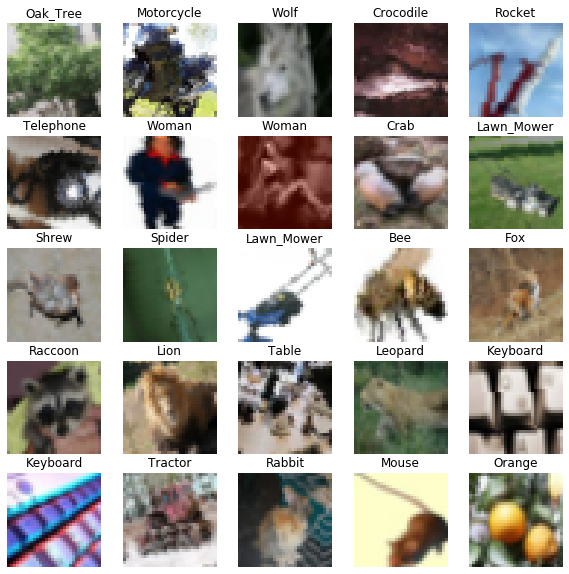

In [86]:
image_batch, label_batch = next(iter(trainDS))
show_batch(image_batch.numpy(), label_batch.numpy())

## Create model

In [87]:
modelDiagramFile = os.path.join(resultsDir, 'model_resnet50_cifar100.png')

model = ResNet.build(32, 32, NUM_CHANNELS, NUM_CLASSES, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)


## Train model

In [88]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
        
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    print('Learning rate: ', lr)
    return lr

In [89]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logsCheckDir + "/metrics")
file_writer.set_as_default()

tb_callback = keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1)
ck_callback = keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5"))
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

callbacks = [tb_callback, ck_callback, lr_callback]

optimizer = tf.optimizers.Adam(learning_rate=lr_schedule(0))

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Learning rate:  0.001


In [90]:
startTime = time.time()

model.fit(trainDS,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          validation_data=valDS,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Learning rate:  0.001
Epoch 1/200
391/391 [==============================] - 37s 96ms/step - loss: 4.3487 - accuracy: 0.1076 - val_loss: 3.9636 - val_accuracy: 0.1586 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
391/391 [==============================] - 36s 91ms/step - loss: 3.7381 - accuracy: 0.2024 - val_loss: 3.7436 - val_accuracy: 0.2079 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
391/391 [==============================] - 36s 91ms/step - loss: 3.3830 - accuracy: 0.2668 - val_loss: 3.2492 - val_accuracy: 0.2822 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
391/391 [==============================] - 36s 91ms/step - loss: 3.1023 - accuracy: 0.3200 - val_loss: 3.0689 - val_accuracy: 0.3189 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
391/391 [==============================] - 36s 91ms/step - loss: 2.8899 - accuracy: 0.3619 - val_loss: 3.0565 - val_accuracy: 0.3327 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
391/391 [==============================] - 36s 91ms/step - loss: 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 35s 90ms/step - loss: 1.4005 - accuracy: 0.7582 - val_loss: 1.9890 - val_accuracy: 0.6353 - lr: 0.0010
Learning rate:  0.001
Epoch 61/200
391/391 [==============================] - 35s 91ms/step - loss: 1.3917 - accuracy: 0.7586 - val_loss: 2.0407 - val_accuracy: 0.6276 - lr: 0.0010
Learning rate:  0.001
Epoch 62/200
391/391 [==============================] - 35s 90ms/step - loss: 1.3763 - accuracy: 0.7647 - val_loss: 2.0618 - val_accuracy: 0.6250 - lr: 0.0010
Learning rate:  0.001
Epoch 63/200
391/391 [==============================] - 35s 91ms/step - loss: 1.3878 - accuracy: 0.7624 - val_loss: 2.0199 - val_accuracy: 0.6292 - lr: 0.0010
Learning rate:  0.001
Epoch 64/200
391/391 [==============================] - 36s 91ms/step - loss: 1.3866 - accuracy: 0.7636 - val_loss: 2.0037 - val_accuracy: 0.6352 - lr: 0.0010
Learning rate:  0.001
Epoch 65/200
391/391 [==============================] - 35s 91ms/step - loss: 1.3678 - accuracy: 0.7682 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 35s 91ms/step - loss: 1.0164 - accuracy: 0.8821 - val_loss: 1.7848 - val_accuracy: 0.6946 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 84/200
391/391 [==============================] - 36s 91ms/step - loss: 0.9849 - accuracy: 0.8920 - val_loss: 1.7800 - val_accuracy: 0.6988 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 85/200
391/391 [==============================] - 35s 91ms/step - loss: 0.9577 - accuracy: 0.8996 - val_loss: 1.7831 - val_accuracy: 0.6986 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 86/200
391/391 [==============================] - 36s 91ms/step - loss: 0.9427 - accuracy: 0.9026 - val_loss: 1.7760 - val_accuracy: 0.6988 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 87/200
391/391 [==============================] - 35s 90ms/step - loss: 0.9221 - accuracy: 0.9091 - val_loss: 1.7870 - val_accuracy: 0.6970 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 88/200
391/391 [==============================] - 35s 91ms/step - loss: 0.912

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 36s 91ms/step - loss: 0.7504 - accuracy: 0.9444 - val_loss: 1.8234 - val_accuracy: 0.6927 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 106/200
391/391 [==============================] - 36s 91ms/step - loss: 0.7475 - accuracy: 0.9439 - val_loss: 1.8224 - val_accuracy: 0.6933 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 107/200
391/391 [==============================] - 35s 91ms/step - loss: 0.7397 - accuracy: 0.9454 - val_loss: 1.8313 - val_accuracy: 0.6921 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 108/200
391/391 [==============================] - 35s 91ms/step - loss: 0.7383 - accuracy: 0.9445 - val_loss: 1.8200 - val_accuracy: 0.6956 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 109/200
391/391 [==============================] - 35s 91ms/step - loss: 0.7268 - accuracy: 0.9466 - val_loss: 1.8229 - val_accuracy: 0.6949 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 110/200
391/391 [==============================] - 35s 91ms/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 35s 90ms/step - loss: 0.6349 - accuracy: 0.9659 - val_loss: 1.8217 - val_accuracy: 0.6932 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 129/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6366 - accuracy: 0.9652 - val_loss: 1.8232 - val_accuracy: 0.6946 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 130/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6353 - accuracy: 0.9663 - val_loss: 1.8200 - val_accuracy: 0.6960 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 131/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6314 - accuracy: 0.9680 - val_loss: 1.8234 - val_accuracy: 0.6948 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 132/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6329 - accuracy: 0.9670 - val_loss: 1.8265 - val_accuracy: 0.6943 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 133/200
391/391 [==============================] - 35s 90ms/step - loss: 0.630

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 35s 90ms/step - loss: 0.6177 - accuracy: 0.9696 - val_loss: 1.8292 - val_accuracy: 0.6941 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 151/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6176 - accuracy: 0.9696 - val_loss: 1.8217 - val_accuracy: 0.6953 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 152/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6158 - accuracy: 0.9705 - val_loss: 1.8274 - val_accuracy: 0.6948 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 153/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6132 - accuracy: 0.9715 - val_loss: 1.8240 - val_accuracy: 0.6963 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 154/200
391/391 [==============================] - 35s 91ms/step - loss: 0.6160 - accuracy: 0.9698 - val_loss: 1.8329 - val_accuracy: 0.6925 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 155/200
391/391 [==============================] - 35s 90ms/step - loss: 0.613

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 35s 90ms/step - loss: 0.6077 - accuracy: 0.9711 - val_loss: 1.8254 - val_accuracy: 0.6957 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 174/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6074 - accuracy: 0.9714 - val_loss: 1.8314 - val_accuracy: 0.6951 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 175/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6078 - accuracy: 0.9710 - val_loss: 1.8319 - val_accuracy: 0.6941 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 176/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6070 - accuracy: 0.9717 - val_loss: 1.8308 - val_accuracy: 0.6953 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 177/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6055 - accuracy: 0.9732 - val_loss: 1.8296 - val_accuracy: 0.6962 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 178/200
391/391 [==============================] - 35s 90ms/step - loss: 0.608

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 35s 90ms/step - loss: 0.6035 - accuracy: 0.9727 - val_loss: 1.8275 - val_accuracy: 0.6960 - lr: 5.0000e-07
Learning rate:  5e-07
Epoch 198/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6045 - accuracy: 0.9729 - val_loss: 1.8266 - val_accuracy: 0.6957 - lr: 5.0000e-07
Learning rate:  5e-07
Epoch 199/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6070 - accuracy: 0.9716 - val_loss: 1.8260 - val_accuracy: 0.6955 - lr: 5.0000e-07
Learning rate:  5e-07
Epoch 200/200
391/391 [==============================] - 35s 90ms/step - loss: 0.6049 - accuracy: 0.9732 - val_loss: 1.8291 - val_accuracy: 0.6957 - lr: 5.0000e-07

Total time for model training: 120.6299799879392 minutes


## Save model

In [107]:
modelFile = os.path.join(modelsDir, 'model_resnet50.h5')

model.save(modelFile)

## Plot confusion matrix

In [91]:
from sklearn.metrics import confusion_matrix

In [104]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [105]:
y_pred=np.argmax(model.predict(testX), axis=1)
y_true=np.argmax(testY, axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization


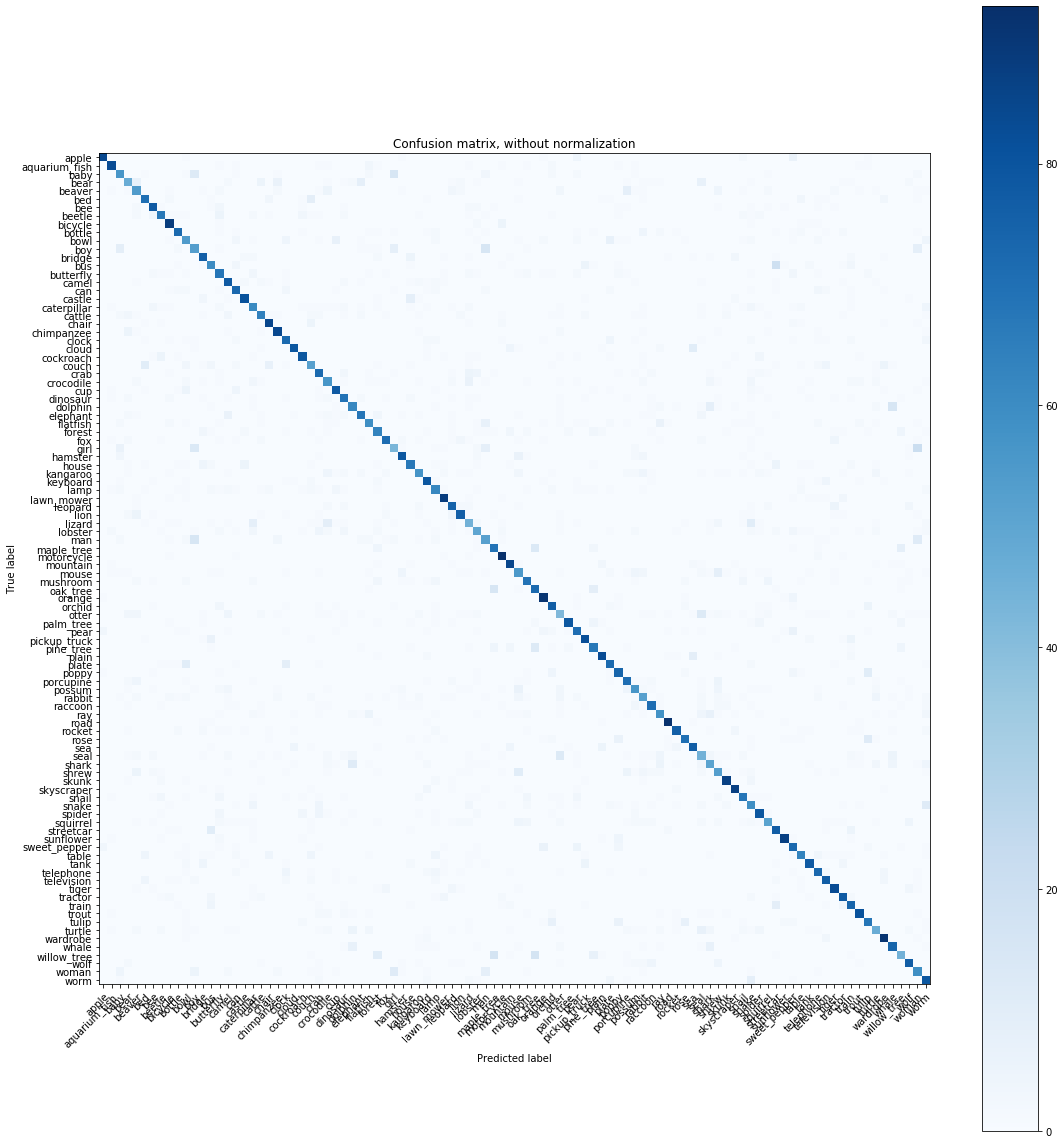

In [106]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=CLASS_NAMES,
                      title='Confusion matrix, without normalization')